This notebook checks if the Gaussian toy model in
[Adversarially Robust Generalization Requires More Data](https://arxiv.org/abs/1804.11285)
exhibits any cliffs.

### Load libraries 

In [1]:
import dataclasses
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from tqdm.auto import tqdm


### Error functions

In [2]:
def normalized(x: np.ndarray):
    return x / np.linalg.norm(x)


@dataclasses.dataclass
class GaussianConfig:
    theta: np.ndarray
    sigma: float
    eps: float

    def __post_init__(self):
        assert np.isclose(np.linalg.norm(self.theta), 1)


def get_robust_errors(
    cfg: GaussianConfig,
    n_train: int,
    n_trials: int,
) -> np.ndarray:
    """Runs n_trial virtual experiments. Returns robust error for each one."""
    (d,) = cfg.theta.shape

    theta_hats = cfg.theta.reshape(1, d) + np.random.normal(
        scale=cfg.sigma / n_train,
        size=(n_trials, d),
    )

    inner_prods = theta_hats @ cfg.theta
    l1_norms = np.linalg.norm(theta_hats, ord=1, axis=-1)
    l2_norms = np.linalg.norm(theta_hats, ord=2, axis=-1)

    zs = (inner_prods - cfg.eps * l1_norms) / (cfg.sigma * l2_norms)
    return scipy.stats.norm.cdf(-zs)


get_robust_errors(
    cfg=GaussianConfig(
        theta=normalized(np.random.normal(size=10)),
        sigma=0.5,
        eps=0.1,
    ),
    n_train=100,
    n_trials=10,
)


array([0.06109101, 0.06132205, 0.06084781, 0.061141  , 0.06114581,
       0.06072337, 0.06147022, 0.0606968 , 0.06114161, 0.06139216])

### Scaling laws

In [3]:
def run_scaling_experiment(
    cfg: GaussianConfig,
    n_trains: list[int],
    n_trials: int = 1,
) -> pd.DataFrame:
    err_mins = []
    err_mids = []
    err_maxs = []
    for n in tqdm(n_trains):
        errs = get_robust_errors(cfg=cfg, n_train=n, n_trials=n_trials)

        err_mins.append(np.min(errs))
        err_mids.append(np.median(errs))
        err_maxs.append(np.max(errs))

    return pd.DataFrame(
        {
            "n_train": n_trains,
            "err_min": err_mins,
            "err_mid": err_mids,
            "err_max": err_maxs,
        }
    )


In [4]:
np.random.seed(42)
cfg_iso = GaussianConfig(
    theta=normalized(np.random.normal(size=1000000)),
    sigma=0.1,
    eps=0,
)

DATA = {}
for eps in [0, 1e-4, 2e-4, 4e-4, 6e-4, 8e-4]:
    DATA[eps] = run_scaling_experiment(
        cfg=dataclasses.replace(cfg_iso, eps=eps),
        n_trains=list(itertools.chain(
            range(1, 50),
            range(50, 100, 2),
            range(100, 200, 4),
            range(200, 400, 10),
            range(400, 1000, 100),
            range(1000, 10000, 1000),
        )),
        n_trials=1,
    )

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

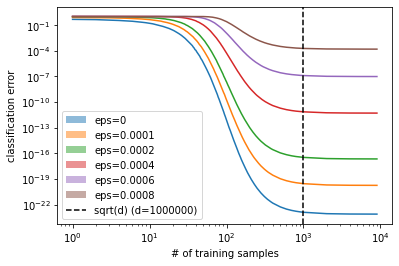

In [6]:
for eps in sorted(DATA.keys()):
    df = DATA[eps]
    plt.plot(df.n_train, df.err_mid)
    plt.fill_between(
        df.n_train,
        df.err_min,
        df.err_max,
        alpha=0.5,
        label=f"{eps=}",
    )
    
plt.axvline(
    np.sqrt(cfg_iso.theta.size),
    color="black",
    linestyle="--",
    label=f"sqrt(d) (d={cfg_iso.theta.size})"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("# of training samples")
plt.ylabel("classification error")
plt.legend();


### Conclusions

The toy model does exhibit a soft "cliff",
but not as a result of the adversary.
In fact, adding an adversary only decreases the slope of the cliff.